In [13]:
# import libraries
%matplotlib widget
import trackpy as tp
tp.quiet()
from scipy.ndimage import gaussian_filter
from math import *

from numpy.linalg import norm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
# import sdt
# from sdt import io, multicolor, brightness #chromatic

import scipy.io
import pims
import os
import pickle
import re
import matplotlib.patches as patches
from glob import glob
import copy
from sdt import nbui, io


import sympy as sy

In [14]:
def transform(df,x_shift,y_shift,phi):
    phi = np.radians(phi)
    df['x']= np.cos(phi)*df['x']-np.sin(phi)*df['y']
    df['x'] = df['x'] + x_shift
    df['y']= np.sin(phi)*df['x']+np.cos(phi)*df['y']
    df['y'] = df['y'] + y_shift
    return df

# import fibril data

In [15]:
# Load the whole ROI and make the overlay
# Save the overlay parameters to the table
# Cutout all predefined fibrils with the bg cutting out

In [16]:
# STORM localisations
List_of_val = pd.read_csv('List_of_val.csv')

# Define the ROI you would like to analyze:
ROI = '2_1_2'
fibril = '5_2'
ROI_folder = f'{ROI}_fib{fibril}'
defocus = List_of_val[List_of_val['fibril']== f'{fibril}']['defocus'].iloc[0]
mid_layer = List_of_val[List_of_val['fibril']== f'{fibril}']['middle_layer'].iloc[0]


folder = f'loc_filt_GPU_results_{ROI}/fibril_{fibril}/tilt_correction/'
file = f'STORM_localisations_filtered_ROI_{ROI}_fibril_{fibril}_def_{defocus}_mid_{mid_layer}_n133_n1.33_n1518.csv'
STORM_locs = pd.read_csv(folder+'/'+file)
# locs = locs.drop(['Unnamed: 0','id'],axis=1)
# STORM_locs = STORM_locs.rename(columns = {'x_cor':'x','y_cor':'y',
#                                           'z [nm]':'z','signal / photons':'N',
#                                           'BG / photons':'bg'})
print('STORM file is loaded') 
    
    
# import AFM file
a,b,c = ROI.split('_')
pattern_ROI = '2022_02_0'+f'{a}'+'_Nr'+f'{b}'+'_ROI'+f'{c}_Qi_liquid-data.csv'
folder_path = 'AFM_PointClouds_2024_10_11_corrected/'
files_in_folder = os.listdir(folder_path)
files_only = [f for f in files_in_folder if os.path.isfile(os.path.join(folder_path, f))]

search_string = []
for index,k in enumerate(files_only):
    if pattern_ROI in k and '.csv' in k:
        search_string = [index,k.find(pattern_ROI)]
        AFM_Qi = pd.read_csv(folder_path+files_only[search_string[0]])
        AFM_Qi.columns = ['x', 'y', 'z']
        AFM_Qi = AFM_Qi*10**9
        
        print('AFM file is loaded')        
if search_string == []:
    print('no pattern found - please check the year 2022'+
          '- 2023 in the list of files')

STORM file is loaded
AFM file is loaded


# Overlay

In [1]:
# The overlay is performed using defined transformation parameters (rotation and translation)
# Those parameters have been determined using the whole ROIs 
# of the AFM and SMLM image, not single fibrils

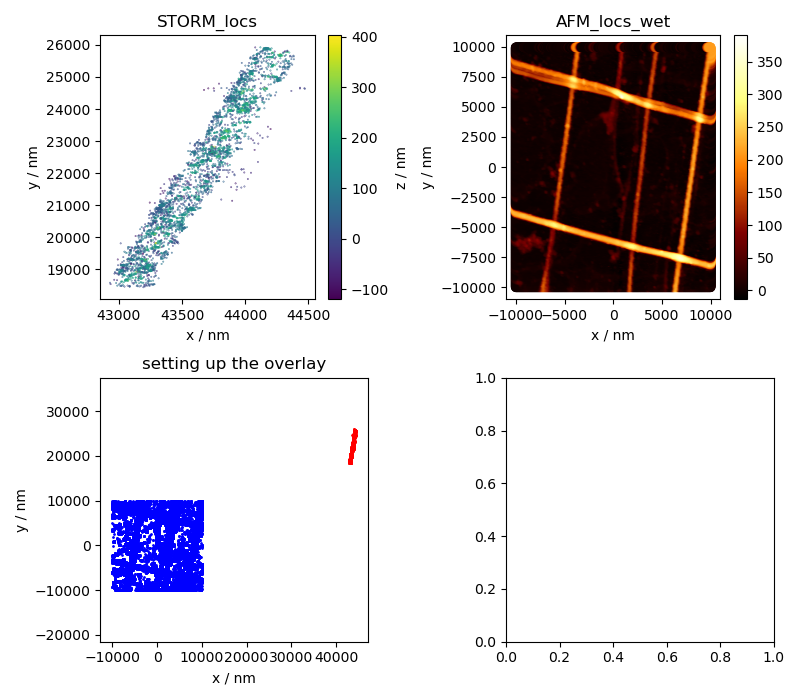

In [17]:
# plot the localisations in x,y:

fig_trio, ax = plt.subplots(2,2,figsize=(8,7))

# # plot STORM_locs
s1 = ax[0][0].scatter(STORM_locs['x'], STORM_locs['y'], c=STORM_locs['z'], s=0.1)
plt.colorbar(s1, label='z / nm',ax = ax[0][0])
ax[0][0].set_xlabel('x / nm')
ax[0][0].set_ylabel('y / nm')
ax[0][0].set_title('STORM_locs')

# plot AFM_locs_wet
s2 = ax[0][1].scatter(AFM_Qi['x'],AFM_Qi['y'],c = AFM_Qi['z'],cmap='afmhot')
plt.colorbar(s2,ax = ax[0][1])
ax[0][1].set_xlabel('x / nm')
ax[0][1].set_ylabel('y / nm')
ax[0][1].set_title('AFM_locs_wet')

ax[1][0].scatter(STORM_locs['x'], STORM_locs['y'],
                    color = 'red',s = 1, alpha = 1,label = 'STORM')
ax[1][0].scatter(AFM_Qi[AFM_Qi['z']>10]['x'], 
                    AFM_Qi[AFM_Qi['z']>10]['y'],
                    color = 'blue',s = 1, alpha = 1,label = 'AFM_wet')
ax[1][0].set_xlabel('x / nm')
ax[1][0].set_ylabel('y / nm')
ax[1][0].set_title('setting up the overlay')
ax[1][0].axis('equal')


plt.tight_layout()
# fig_trio.savefig(sample_ROI+'/'+sample_ROI+'_trio.png',dpi = 600)
plt.show()

transformation is already there
{'ROI': nan, 'sdx': 3000.0, 'sdy': 21000.0, 'pd': 0.0, 'swx': 35900.0, 'swy': 23200.0, 'pw': 0.0}
Do you want to change the parameters ?
old transformation used


((24901.953125, 46858.984375, 12201.953125, 34158.984375),
 None)

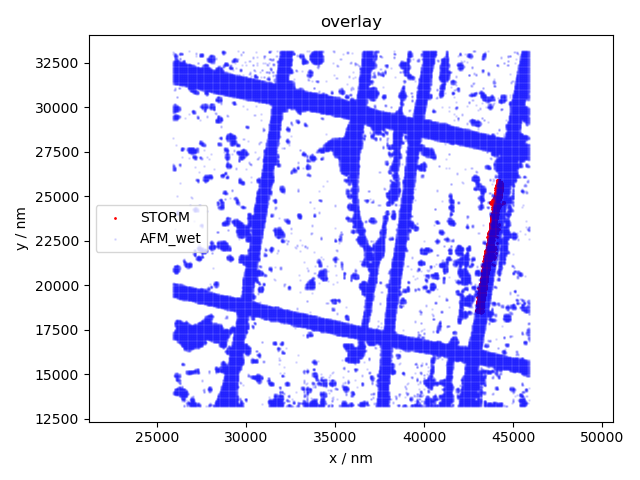

In [18]:
# Load the Overlay_table file
pickle_in = open("Overlay_table.pkl","rb")
Overlay_table = pickle.load(pickle_in)
# Overlay_table = pd.DataFrame(columns=('ROI','sdx','sdy','pd','swx','swy','pw'))
# s stands for transformation in each direction x,y and z
# p for rotation angel phi
# d for dry and w for wet

if ROI in Overlay_table.index:
    T = Overlay_table.loc[ROI]
    T = T.to_dict()
    print('transformation is already there')
    print(T)
    
    Q1 = input('Do you want to change the parameters ?')
    if Q1 == 'y':
        # Change parameters if necessary
        T = {'swx':35900,'swy':23200,'pw':0, # Wet AFM
             'sdx':3000,'sdy':21000,'pd':0} # Dry AFM
        Overlay_table.loc[ROI] = T
        
        with open('Overlay_table.pkl', 'wb') as file:
            pickle.dump(Overlay_table,file) 
    else:
        print('old transformation used')

else:
    Td = {'sdx':3000,'sdy':21000,'pd':0}
    T = {'swx':35900,'swy':23300,'pw':0}
    
    T.update(Td)
    new_row = pd.DataFrame([T],index = [ROI])
    Overlay_table = pd.concat([Overlay_table, new_row])
    print('defining new transformation')
    with open('Overlay_table.pkl', 'wb') as file:
        pickle.dump(Overlay_table,file) 
    
S_try = STORM_locs.copy()
Aw_try = AFM_Qi.copy() # AFM wet data
# Ad_try = transform(Ad_try,Td['sdx'],Td['sdy'],Td['pd'])
Aw_try = transform(Aw_try,T['swx'],T['swy'],T['pw'])


# plot the localisations in x,y:
fig_overlay, ax1 = plt.subplots()
ax1.scatter(S_try['x'], S_try['y'],
                    color = 'red',s = 1, alpha = 1,label = 'STORM')
ax1.scatter(Aw_try[Aw_try['z']>10]['x'], 
                    Aw_try[Aw_try['z']>10]['y'],
                    color = 'blue',s = 1, alpha = .1,label = f'AFM_wet')

ax1.set_xlabel('x / nm'), ax1.set_ylabel('y / nm'), ax1.set_title('overlay')
ax1.axis('equal'), ax1.legend(), plt.tight_layout()

# fig_overlay.savefig(sample_ROI+'/'+sample_ROI+'_overlay.png',dpi = 600)
# plt.show()

In [19]:
Overlay_table

,ROI,sdx,sdy,pd,swx,swy,pw
2_1_2,NaN,3000.0,21000.0,0.0,35900.0,23200.0,0.0
2_1_3,NaN,3000.0,21000.0,0.0,43000.0,21000.0,2.0


# Cut out the individual fibrils all at once

In [ ]:
# This ensures that the same fibril region is taken from the 
# AFM measurements and the SMLM measurements

In [20]:
with open('fibril_cutouts.pkl', 'rb') as file:
    fibril_cutouts = pickle.load(file) 

In [21]:
# Make a list of all fibrils within one ROI:
ROI_cutouts = fibril_cutouts[fibril_cutouts['ROI'] == ROI]
List_of_fibs =  ROI_cutouts['fibril']

In [22]:

# If the list of fibrils does not yet exist, make a new one

for k in List_of_fibs:
    try:
        os.makedirs(f'AFM_locs_{ROI}/fibril_{k}')
        print('new folder created')
    except FileExistsError:
        print('Folder already exists')

Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists
Folder already exists


In [23]:
fibril_cutouts

,ROI,fibril,path_fib,path_bg
0,2_1_2,4_1,"Path(array([[37340.40454455, 15576.68582521],\...","Path(array([[33400.11623276, 17041.90564862],\..."
1,2_1_2,4_2,"Path(array([[38783.87281767, 26646.64203829],\...","Path(array([[36714.78717632, 28917.04037642],\..."
2,2_1_2,2_1,"Path(array([[24502.78924036, 20635.03603753],\...","Path(array([[25352.5341027 , 23314.48204034],\..."
3,2_1_2,2_2,"Path(array([[30974.49411759, 19524.99318274],\...","Path(array([[30687.13225012, 19525.3609154 ],\..."
4,2_1_2,2_3,"Path(array([[43954.78900016, 16142.16280104],\...","Path(array([[43394.20413776, 14839.29764674],\..."
5,2_1_2,5_1,"Path(array([[42036.32403865, 14941.69241073],\...","Path(array([[38847.31349445, 16091.33902882],\..."
6,2_1_2,5_2,"Path(array([[43973.4179802 , 26743.35186676],\...","Path(array([[40207.28184677, 28070.76094922],\..."
7,2_1_2,4_3,"Path(array([[40210.799919 , 37718.0943921 ],\...","Path(array([[38556.70723586, 37317.46760738],\..."


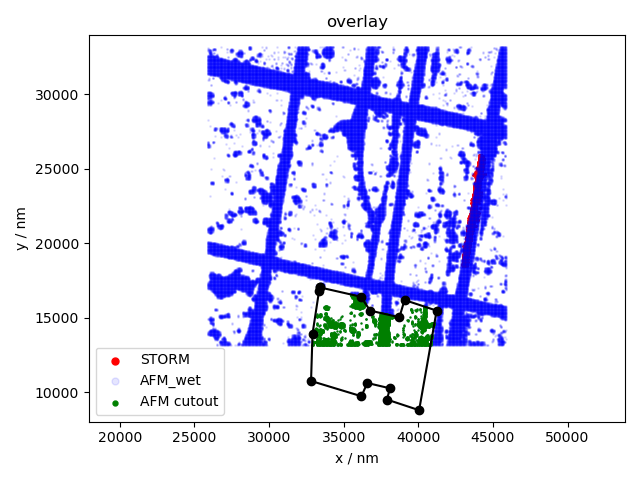

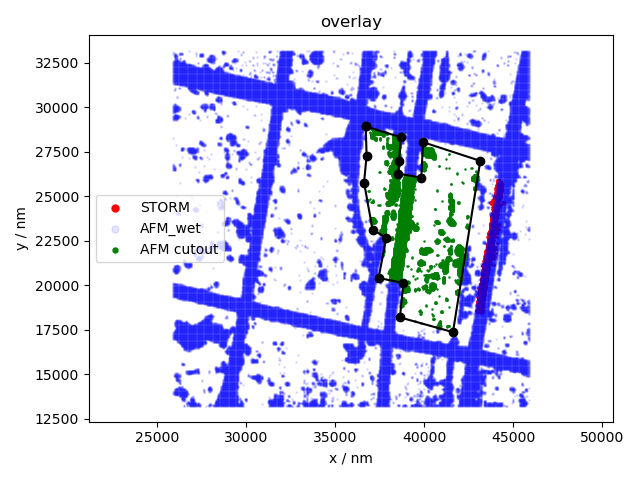

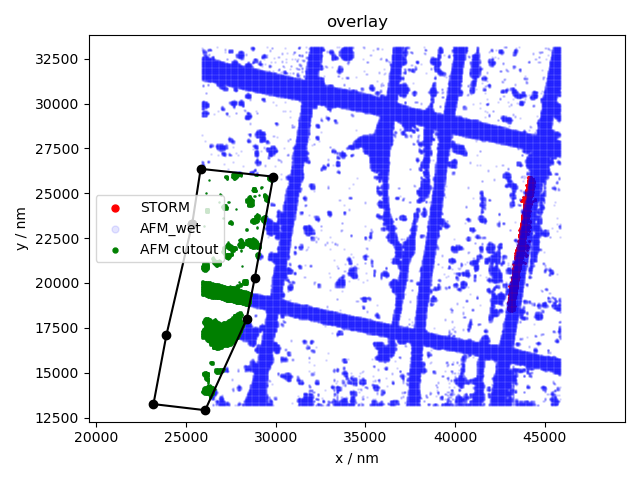

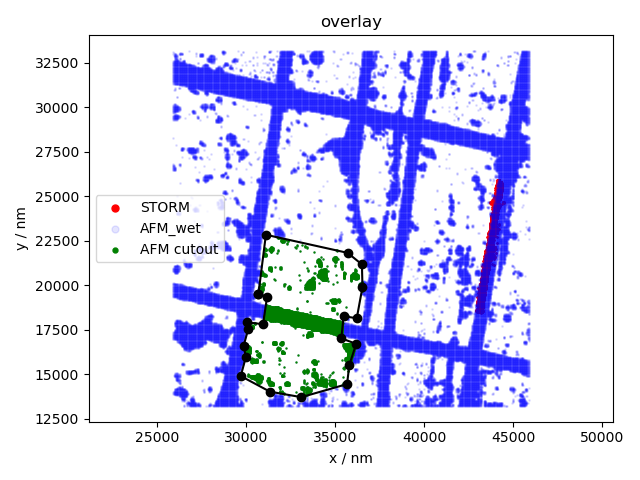

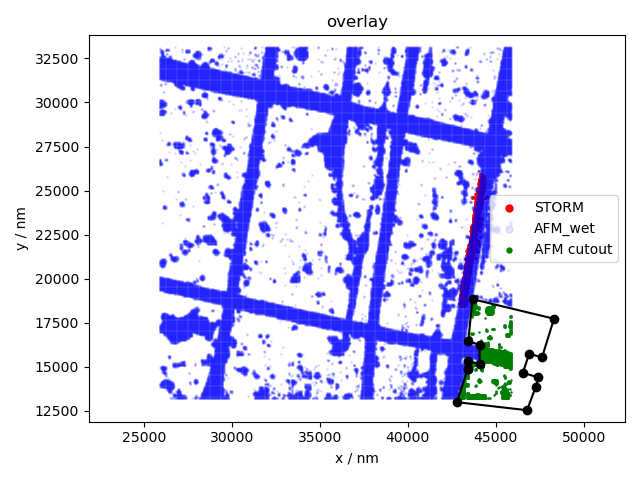

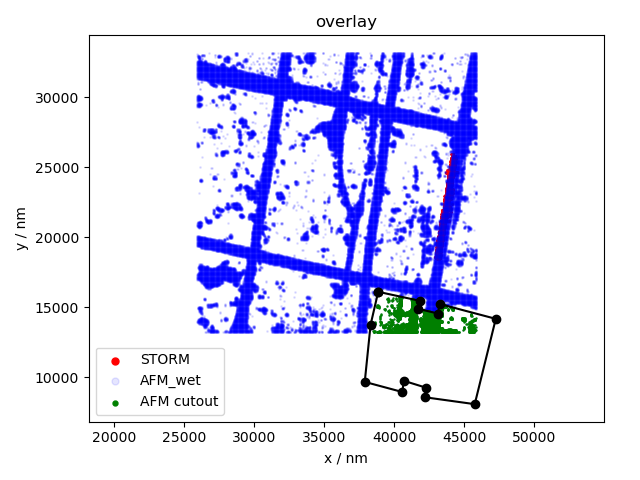

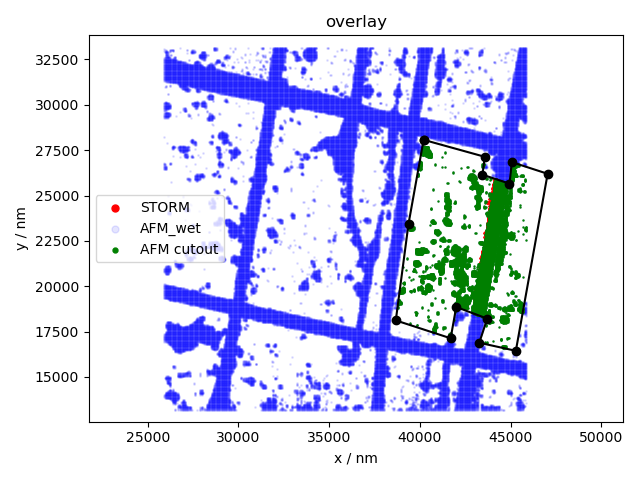

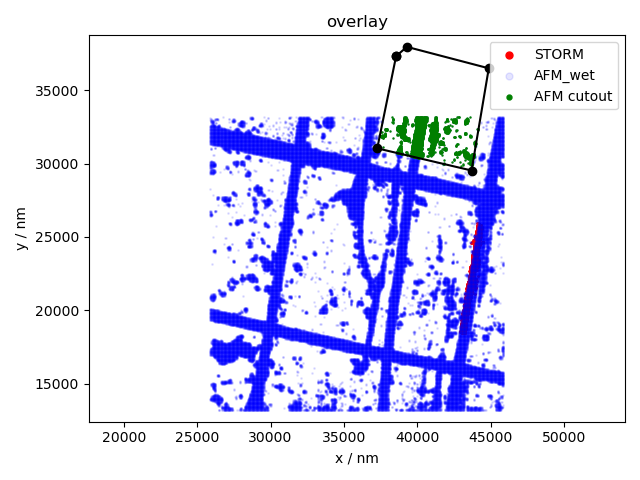

In [24]:


# for the same ROI, cutout the AFM fibrils and save it
# in each fibril folder

saving_folder = f'AFM_locs_{ROI}/'

for fib in List_of_fibs:
    ROI_cutouts_copy = ROI_cutouts.copy()
    ROI_cutouts_copy = ROI_cutouts_copy[ROI_cutouts_copy['fibril']==fib]
    path_bg = ROI_cutouts_copy['path_bg'].iloc[0]
    
    # Cutout AFM Wet fibril
    Aw_try_sp = np.column_stack([Aw_try['x'], Aw_try['y']]) #scatter_pos
    Aw_try_selected = path_bg.contains_points(Aw_try_sp)
    Aw_try_fib_locs = Aw_try[Aw_try_selected]
    
    Saving_path = saving_folder+f'fibril_{fib}/'
    Aw_try_fib_locs.to_csv(Saving_path+f'AFM_wet_ROI_{ROI}_fibril_{fib}.csv')
    
    # To visualize the cutout
    # Extract coordinates from the Path object
    x, y = path_bg.vertices[:, 0], path_bg.vertices[:, 1]

    # Add the starting point at the end to close the outline
    x = np.append(x, x[0])
    y = np.append(y, y[0])


    # plot the localisations in x,y:
    fig_overlay, ax1 = plt.subplots()
    ax1.scatter(S_try['x'], S_try['y'],
                        color = 'red',s = 1, alpha = 1,label = 'STORM')
    ax1.scatter(Aw_try[Aw_try['z']>10]['x'], 
                        Aw_try[Aw_try['z']>10]['y'],
                        color = 'blue',s = 1, alpha = .1,label = f'AFM_wet')
    ax1.scatter(Aw_try_fib_locs[Aw_try_fib_locs['z']>10]['x'], 
                        Aw_try_fib_locs[Aw_try_fib_locs['z']>10]['y'],
                        color = 'g',s=0.5,label = 'AFM cutout')

    # Plot the cutout outline using a simple line plot
    ax1.plot(x, y, '-o', color='k')

    ax1.set_xlabel('x / nm'), ax1.set_ylabel('y / nm'), ax1.set_title('overlay')
    ax1.axis('equal'), ax1.legend(markerscale = 5), plt.tight_layout()
#     fig_overlay.savefig(Saving_path+'overlay.png',dpi = 600)
